In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
import multiprocessing
import os.path
import csv
import copy
import joblib
from torchvision import datasets
import torchvision
import seaborn as sns; sns.set(color_codes=True)
from torch.utils.data import DataLoader
sns.set_style("white")

In [4]:
# Change USE_CUDA to True when running on GPU
USE_CUDA  = True

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v


In [5]:
!mkdir -p _cache
cache = joblib.Memory(location='_cache', verbose=0)


In [6]:
# This function is responsible for disabling the propagation of certain variable gradients
def detach_var(v):
    var = w(Variable(v.data, requires_grad=True))
    var.retain_grad()
    return var

In [7]:
def fit(optimizer_network, meta_optimizer, optimizee_obj_function, optimizee_network,
        iterations_to_optimize, iterations_to_unroll, out_mul,
        should_train = True):
    """
    Arguments: 
    - optimizer_network (the optimizer network we use, here the LSTM)
    - meta_optimizer (the optimizer of the optimizer network, e.g. Adam, SGD + nesterov, RMSprop, etc.)
    - optimizee_obj_function (the optimizee's objective function)
    - optimizee_network (the optimizee network)
    - epochs (total epochs for training)
    - iterations_to_optimize (iterations in every epoch)
    - should_train (if should_train is True, then we just train the optimizer, else we evaluate)
    """
    
    if should_train:
        optimizer_network.train()
    else:
        optimizer_network.eval()
        unroll = 1

    optimizee_obj_function = optimizee_obj_function(training=should_train)
    optimizee = w(optimizee_network())
    
    # Counting the parameters of the optimizee
    n_params = 0
    for param in optimizee.parameters():
        n_params += int(np.prod(param.size()))
        
    hidden_states = [w(Variable(torch.zeros(n_params, optimizer_network.hidden_size))) for _ in range(2)]
    cell_states = [w(Variable(torch.zeros(n_params, optimizer_network.hidden_size))) for _ in range(2)]
    
    losses_list = []
    
    if should_train:
        meta_optimizer.zero_grad()
        
    total_losses = None
    
    for iteration in range(iterations_to_optimize):
        
        # The loss of the current iteration
        current_loss = optimizee(optimizee_obj_function)
        
        # Since the objective function of the optimizer is equal to the sum of the optimizee's losses
        # we want to measure the loss of every iteration and add it to the total sum of losses
        if total_losses is None:
            total_losses = current_loss
        else:
            total_losses += current_loss
            
        losses_list.append(current_loss.data.cpu().numpy())
        # Here dloss/dx is computed for every parameter x that has requires_grad = True
        # These are accumulated into x.grad for every parameter x
        # This is equal to x.grad += dloss/dx
        
        # We get the optimizee's gradients but we also retain the graph because
        # we need to run backpropagation again when we optimize the optimizer
        current_loss.backward(retain_graph = True)
        
        offset = 0
        result_params = {}
        
        # These will be the new parameters. We will update all the parameters, cell and hidden states
        # by iterating through the optimizee's "all_named parameters"
        hidden_states2 = [w(Variable(torch.zeros(n_params, optimizer_network.hidden_size))) for _ in range(2)]
        cell_states2 = [w(Variable(torch.zeros(n_params, optimizer_network.hidden_size))) for _ in range(2)]
        
        for name, param in optimizee.all_named_parameters():
            current_size = int(np.prod(param.size()))
            # We want to disconnect the gradients of some variables but not all, each time.
            
            # We do this in order to disconnect the gradients of the offset:offset+current_size
            # parameters but still get the gradients of the rest.
            gradients = detach_var(param.grad.view(current_size, 1))
            
            # Call the optimizer and compute the new parameters
            updates, new_hidden, new_cell = optimizer_network(
                gradients,
                [h[offset:offset+current_size] for h in hidden_states],
                [c[offset:offset+current_size] for c in cell_states]
            )
            
            # Here we replace the old parameters with the new values
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+current_size] = new_hidden[i]
                cell_states2[i][offset:offset+current_size] = new_cell[i]
            
            result_params[name] = param + updates.view(*param.size()) * out_mul
            result_params[name].retain_grad()
        
        # If we have reached the number of iterations needed to update the optimizer
        # we run backprop on the optimizer network
        if iteration % iterations_to_unroll == 0:
            if should_train:
                # zero_grad() clears the gradients of all optimized tensors
                meta_optimizer.zero_grad()
                # we compute the gradient of the total losses  (i.e. the optimizer's loss function)
                # with respect to the optimizer's parameters
                total_losses.backward()
                # we finally perform the optimization step, i.e. the updates
                meta_optimizer.step()
                
            # Since we did the update on the optimizer network
            # we overwrite the total_losses
            total_losses = None
            
            # Here we detach the state variables because they are not propagated
            # to the graph (see Figure 2 of the paper for details)
            optimizee = w(optimizee_network(**{k: detach_var(v) for k, v in result_params.items()}))
            hidden_states = [detach_var(v) for v in hidden_states2]
            cell_states = [detach_var(v) for v in cell_states2]
        else:
            # Otherwise, we just create the next optimizee objective funtion
            optimizee = w(optimizee_network(**result_params))
            hidden_states = hidden_states2
            cell_states = cell_states2
            
    return losses_list

In [8]:
@cache.cache
def main_loop(optimizee_obj_function, optimizee_network, preprocessing = False,
        epochs = 20, iterations_to_optimize = 100, iterations_to_unroll = 20, 
        n_tests = 100, lr = 0.001, out_mul = 1.0):
    
    optimizer_network = w(OptimizerNetwork(preprocessing = preprocessing))
    
    # To construct an Optimizer you need to give it an iterable containing the parameters to optimize
    meta_optimizer = optim.Adam(optimizer_network.parameters(), lr = lr)
    
    # Initialize dummy variables for the best_net object and the best_loss
    best_net = None
    best_loss = 10000000000000000
    
    for _ in tqdm(range(epochs), 'epochs'):
        for _ in tqdm(range(iterations_to_optimize), 'iterations'):
            fit(optimizer_network, meta_optimizer, optimizee_obj_function, optimizee_network,
                iterations_to_optimize, iterations_to_unroll, out_mul,
                should_train = True)
            
        current_loss = (np.mean([
                np.sum(fit(optimizer_network, meta_optimizer, optimizee_obj_function, optimizee_network,
                iterations_to_optimize, iterations_to_unroll, out_mul,
                should_train = False))
                for _ in tqdm(range(n_tests), 'tests')
               ]))
        print(current_loss)
        
        if current_loss < best_loss:
            best_loss = current_loss
            best_net = copy.deepcopy(optimizer_network.state_dict())
    
    return best_loss, best_net

For our first experiment we are going to use randomly generated $W$ and $y$. The matrix $W$ will be of dimensions 10x10 and will correspond to the weights that we want to learn, and the vector $y$ will be a 10-element vector that will represent the labels. Our optimizer will try to find a 10-element vector $\theta$ that, when multiplied by $W$ will be as close as possible to y. Hence, our objective function that we want to minimize will be the squared error, i.e.:

$$
\sum^{n}_{k = 1} (w_{i}^T \cdot \theta_{i} - y_{i})^{2}
$$

where $w_{i}$ is the $i$-th column vector of the $W$ matrix.

In [9]:
class RandomQuadraticLoss:
    def __init__(self, **kwargs):
        self.W = w(Variable(torch.randn(10, 10)))
        self.y = w(Variable(torch.randn(10)))
    
    def get_loss(self, theta):
        return torch.sum((self.W.matmul(theta) - self.y) ** 2)
    

class QuadraticOptimizee(nn.Module):
    def __init__(self, theta = None):
        super().__init__()
        
        if theta is None:
            self.theta = nn.Parameter(torch.zeros(10))
        else:
            self.theta = theta
            
    def forward(self, target):
        return target.get_loss(self.theta)
    
    def all_named_parameters(self):
        return [('theta', self.theta)]
    
# Here we declare the optimizer. Here we have a parameter called preproc which is used in order to implement
# what is described as "Gradient preprocessing" in Appendix A. Generally the input to the optimizer network is
# a gradient which can get very high or very small values, especially when we're dealing with complex architectures.
# Due to this, the optimizer training is susceptible to high variance in gradient values, as neural nets prefer to
# deal with a relatively small range of values. Therefore a means of normalizing the gradients needs to be implemented.

# The preprocessing factor is the p > 0 parameter in that paper section, which controls how small gradients are disregarded. It has
# a default value of 10.0

class OptimizerNetwork(nn.Module):
    def __init__(self, preprocessing = False, hidden_size = 20, preprocessing_factor = 10.0):
        super(OptimizerNetwork, self).__init__()
        self.hidden_size = hidden_size
        
        if preprocessing:
            # Since we have the preprocessing flag enabled, we want the neural network
            # to have two arguments and not just the gradient (see the forward function)
            self.recurs = nn.LSTMCell(2, hidden_size)
        else:
            self.recurs = nn.LSTMCell(1, hidden_size)
            
        self.recurs2 = nn.LSTMCell(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.preprocessing = preprocessing
        self.preprocessing_factor = preprocessing_factor
        self.preprocessing_threshold = np.exp(-preprocessing_factor)
        
    def forward(self, inp, hidden, cell):
        if self.preprocessing:
            inp = inp.data
            inp2 = w(torch.zeros(inp.size()[0], 2))
            keep_grads = torch.abs(inp) >= self.preprocessing_threshold
            
            # If the absolute value is greater or equal than the preprocessing threshold
            # (see the condition in the first part of the gradient winged formula) we pass
            # the log of the absolute value of the gradient divided by the preprocessing factor
            # as the first parameter, and we pass the sign of the gradient as the second parameter.

            keep_grads_numpy = keep_grads.data.cpu().numpy()
            
            for i in range(0, keep_grads_numpy.shape[0]):
                
                if keep_grads_numpy[i][0] == 0:
                    inp2[i, 0] = -1
                    inp2[i, 1] = float(np.exp(self.preprocessing_factor)) * inp[i]
                else:
                    inp2[i, 0] = torch.log(torch.abs(inp[i]) + 1e-8) / self.preprocessing_factor
                    inp2[i, 1] = torch.sign(inp[i])

            inp = w(Variable(inp2))
        
        hidden0, cell0 = self.recurs(inp, (hidden[0], cell[0]))
        hidden1, cell1 = self.recurs2(hidden0, (hidden[1], cell[1]))
        
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)

Now, we are going to try several values for the learning rate, in order to find the most promising one for our first experiment which is going to be to minimize the random quadratic loss we declared previously. We are going to use 20 epochs in order to find the best value for our learning rate.

In [9]:
for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
    print('Testing lr:', lr)
    print(main_loop(RandomQuadraticLoss, QuadraticOptimizee, lr = lr)[0])

Testing lr: 1.0
1.06151e+06
3.87047e+06
407286.0
534244.0
765852.0
4.57189e+09
8.33982e+06
2.33666e+07
4.39066e+06
9.84207e+07
6.51848e+07
6.78243e+06
4.01837e+06
6.02287e+06
4.35796e+06
3.00438e+06
1.77599e+06
4.84486e+06
4.34985e+06
1.25905e+07
407286.0
Testing lr: 0.3
4031.45
455.328
273.603
220.825
230.273
435.548
534.906
157.809
188.834
200.797
180.659
193.215
344.052
228.92
5933.04
1.53512e+06
130894.0
51884.8
31189.5
17763.8
157.809
Testing lr: 0.1
148.812
159.561
114.296
109.882
97.5192
94.0384
93.3921
92.5606
17568.0
1293.77
588.901
216.998
14470.8
4072.27
18896.7
1848.27
940.256
704.581
1140.3
1046.93
92.5606
Testing lr: 0.03
77.7415
64.2912
66.536
81.7156
72.0763
64.8456
105.623
83.2872
118.904
75.2233
73.6337
76.4187
72.8018
137.485
336.7
157.997
148.569
117.812
140.621
131.31
64.2912
Testing lr: 0.01
71.6388
116.962
79.9034
76.8655
69.0387
69.4021
131.285
73.5042
70.6852
68.3279
89.895
74.8241
88.2639
73.7223
72.2352
72.5936
61.9325
75.8986
81.9282
92.6235
61.9325
Testing 

Now we are going to see what the best loss is for lr = 0.003 if we train for 100 epochs.

In [11]:
best_loss, best_quadratic_optimizer = main_loop(RandomQuadraticLoss, QuadraticOptimizee, lr = 0.003, epochs = 100)
print(best_loss)

108.609
113.748
95.8785
80.122
67.8811
68.2783
73.4936
76.2695
69.71
75.4591
62.1857
70.8323
68.0931
66.3973
66.408
69.6129
56.3327
78.2214
71.7585
66.4894
104.711
59.9116
58.0487
49.6069
50.986
56.1802
62.3629
69.0708
68.3075
81.6906
86.4789
69.5712
69.7695
73.9057
76.6104
78.7577
68.8004
59.5378
53.0639
61.9818
76.6452
79.668
68.75
67.7073
73.4843
65.4782
70.7025
87.2304
60.1031
60.104
66.8577
58.6507
86.7694
61.647
86.2959
62.7017
90.4795
75.8363
70.1006
61.7037
74.1913
72.0104
59.5791
64.6863
66.3685
78.9243
84.673
110.828
75.9578
83.2141
73.8711
63.5453
83.8761
70.7716
97.542
80.7705
64.2083
69.195
62.4287
96.1141
81.9226
57.3749
67.7085
64.8066
86.1018
76.3642
69.2513
67.9408
75.3665
85.1124
76.6482
76.1039
75.8512
76.2322
73.3325
64.3135
77.3655
84.3747
74.4416
77.4708

49.6069


Now we will find the best learning rate values for a selection of standard optimization algorithms (namely Adam, RMSprop, SGD and SGD with nesterov momentum).

In [10]:
@cache.cache
def fit_normal(optimizee_objective_function, optimizee_network, optimizer_name,
               n_tests = 100, epochs = 100, **kwargs):
    results = []
    
    for i in tqdm(range(n_tests), 'tests'):
        objective_function = optimizee_objective_function(training = False)
        optimizee = w(optimizee_network())
        # Get the parameters of the optimizee in order to optimize them
        
        # Initialize the optimizer object
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(optimizee.parameters(), **kwargs)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(optimizee.parameters(), **kwargs)
        elif optimizer_name == 'SGD':
            optimizer = optim.SGD(optimizee.parameters(), **kwargs)
        else:
            optimizer = optim.SGD(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(epochs):
            current_loss = optimizee(objective_function)
            
            total_loss.append(current_loss.data.cpu().numpy())
            
            optimizer.zero_grad()
            current_loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

def find_best_lr_normal(optimizee_objective_function, optimizee_network, optimizer, **extra_kwargs):
    best_loss = 10000000000000000.0
    best_lr = 0.0
    
    for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning Rates'):
        loss = best_loss + 1.0
        loss = np.mean([np.sum(s) for s in fit_normal(optimizee_objective_function, optimizee_network, optimizer, 
                                                      lr = lr, **extra_kwargs)])

        if loss < best_loss:
            best_loss = loss
            best_lr = lr
            
    return best_loss, best_lr
    

In [11]:
OPTIMIZER_NAMES = ['Adam', 'RMSprop', 'SGD', 'SGD + Momentum']
OPTIMIZER_PARAMETERS = [{}, {}, {}, {'nesterov': True, 'momentum': 0.9}]

In [34]:
for optimizer_name, kwargs in zip(OPTIMIZER_NAMES, OPTIMIZER_PARAMETERS):
    print(find_best_lr_normal(RandomQuadraticLoss, QuadraticOptimizee, optimizer_name, **kwargs))

Adam {}

(98.751038, 0.1)
RMSprop {}

(133.53325, 0.03)
SGD {}

(206.52986, 0.01)
SGD + Momentum {'nesterov': True, 'momentum': 0.9}

(107.54028, 0.01)


In [54]:
QUAD_LEARNING_RATES = [0.1, 0.03, 0.01, 0.01]
fit_data = np.zeros((100, 100, len(OPTIMIZER_NAMES) + 1))

for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), QUAD_LEARNING_RATES)):
    np.random.seed(1234)
    fit_data[:, :, i] = np.array(fit_normal(RandomQuadraticLoss, QuadraticOptimizee, opt, lr = lr, **extra_kwargs))
    
opt = w(OptimizerNetwork())
opt.load_state_dict(best_quadratic_optimizer)
np.random.seed(1234)
fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array([fit(opt, None, RandomQuadraticLoss, QuadraticOptimizee, 
                                                100, 1, out_mul = 1.0, should_train = False) for _ in range(100)])


Finally, we will plot the learning curves for the meta-optimized network (LSTM) vs the selection of the alternative standard algorithms.

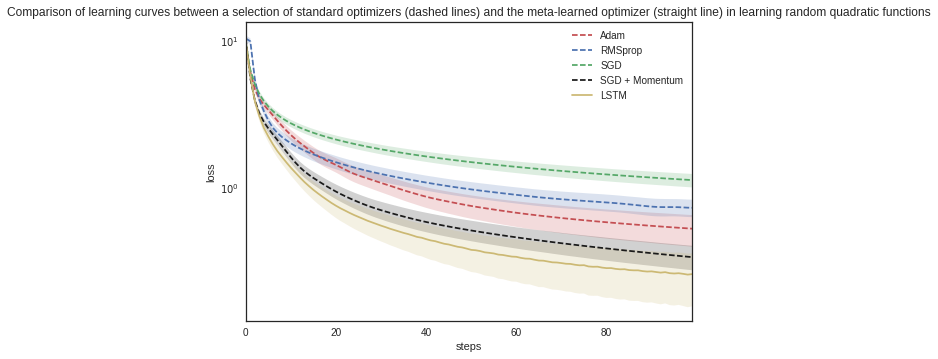

In [55]:
ax = sns.tsplot(data = fit_data[:, :, :], condition = OPTIMIZER_NAMES + ['LSTM'], linestyle = '--', color = ['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title("Comparison of learning curves between a selection of standard optimizers (dashed lines) and the meta-learned optimizer (straight line) in learning random quadratic functions")
plt.show()

In [12]:
class MNISTUtil:
    def __init__(self, training = True):
        # Download the MNIST dataset
        dataset = datasets.MNIST('./mnist', train=True, download=True, transform=torchvision.transforms.ToTensor())
        # Take all the indices in the dataset, shuffle them, then do a training/test split
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]
        
        # Create random samples from the training data in order for them to act as mini-batches
        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128, sampler=torch.utils.data.sampler.SubsetRandomSampler(indices)
        )
        
        self.batches = []
        self.cur_batch = 0
    
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

In [13]:
class GenericNeuralNet(nn.Module):
    def __init__(self, layer_size = 20, n_layers = 1, **kwargs):
        super().__init__()
        if kwargs != {}:
            input_size = 28*28
            self.params = kwargs
        else:
            input_size = 28*28
            self.params = {}
            # Initialize parameter values for weight and bias
            for i in range(n_layers):
                weight_name = 'weight_' + str(i)
                bias_name = 'bias_' + str(i)
                self.params[weight_name] = nn.Parameter(torch.randn(input_size, layer_size) * 0.001)
                self.params[bias_name] = nn.Parameter(torch.zeros(layer_size))
                input_size = layer_size
                
            self.params['final_weight'] = nn.Parameter(torch.randn(input_size, 10) * 0.001)
            self.params['final_bias'] = nn.Parameter(torch.zeros(10))
            
            # Put it all in a module list so that ordinary optimizers can find them.
            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
                
        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()
        
    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))
        
        cur_layer = 0
        while 'weight_' + str(cur_layer) in self.params:
            inp = self.activation(torch.matmul(inp, self.params['weight_' + str(cur_layer)]) + 
                                               self.params['bias_' + str(cur_layer)])
            cur_layer += 1
            
        inp = F.log_softmax(torch.matmul(inp, self.params['final_weight']) + self.params['final_bias'])
        l = self.loss(inp, out)
        
        return l

As we did before, we are going to search for an optimal learning rate using a small number of epochs (10) and optimize it fully using more epochs (50).

In [123]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 
                      key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(main_loop(MNISTUtil, GenericNeuralNet, lr=lr, out_mul=0.1, preprocessing=True, n_tests=5, epochs=10)[0])

Trying lr: 0.01


/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


67.8096
115.554
67.0748
62.6754
70.6006
60.8663
192.742
200.403
69.9209
57.2135
57.2135
230.206
230.187
230.203
230.19
230.204
230.191
230.185
230.183
230.199
230.182
230.19
230.196
230.183
230.201
230.187
230.197
230.188
230.195
230.192
230.205
230.189
230.186
230.191
230.193
230.189
230.197
230.183
230.184
230.2
230.195
230.181
230.181
230.189
230.191
230.194
230.2
230.219
230.195
230.19
230.199
230.184
230.191
230.19
230.191
230.19
230.191
230.191
230.196
230.204
230.201
230.181


In [15]:
best_loss, best_mnist_optimizer = main_loop(MNISTUtil, GenericNeuralNet, lr=0.01, epochs=20, n_tests=20, out_mul=0.1, preprocessing=True)
print(best_loss)

50.8621


In [30]:
for optimizer_name, kwargs in zip(OPTIMIZER_NAMES, OPTIMIZER_PARAMETERS):
    print(find_best_lr_normal(MNISTUtil, GenericNeuralNet, optimizer_name, **kwargs, n_tests=10))

/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(86.209915, 0.03)
(101.40295, 0.01)
(195.05014, 1.0)
(115.88767, 1.0)


/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


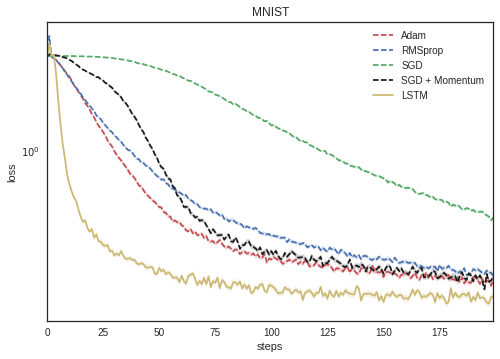

In [141]:
MNIST_LEARNING_RATES = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), MNIST_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTUtil, GenericNeuralNet, opt, lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, best_mnist_optimizer, None, MNISTUtil, GenericNeuralNet, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST')
plt.show()

In [14]:
class GenericNeuralNet2Layer(GenericNeuralNet):
    def __init__(self, *args, **kwargs):
        super().__init__(n_layers=2, *args, **kwargs)
        
class GenericNeuralNetBig(GenericNeuralNet):
    def __init__(self, *args, **kwargs):
        super().__init__(layer_size=40, *args, **kwargs)
        
class GenericNeuralNetRelu(GenericNeuralNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()

In [144]:
for optimizer_name, kwargs in zip(OPTIMIZER_NAMES, OPTIMIZER_PARAMETERS):
    print(find_best_lr_normal(MNISTUtil, GenericNeuralNet2Layer, opt, **kwargs, n_tests=10))

for optimizer_name, kwargs in zip(OPTIMIZER_NAMES, OPTIMIZER_PARAMETERS):
    print(find_best_lr_normal(MNISTUtil, GenericNeuralNetBig, opt, **kwargs, n_tests=10))

for optimizer_name, kwargs in zip(OPTIMIZER_NAMES, OPTIMIZER_PARAMETERS):
    print(find_best_lr_normal(MNISTUtil, GenericNeuralNetRelu, opt, **kwargs, n_tests=10))

/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(230.17485, 0.03)
(230.17485, 0.03)
(230.17485, 0.03)
(202.3468, 1.0)
(187.17001, 1.0)
(187.17001, 1.0)
(187.17001, 1.0)
(123.15172, 1.0)
(155.56615, 1.0)
(155.56615, 1.0)
(155.56615, 1.0)
(90.322403, 0.3)


In [ ]:
MNIST_2LAYER_LEARNING_RATES = [0.03, 0.03, 0.03, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), MNIST_2LAYER_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTUtil, GenericNeuralNet2Layer, opt, lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTUtil, GenericNeuralNet2Layer, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (2 hidden layers)')
plt.show()

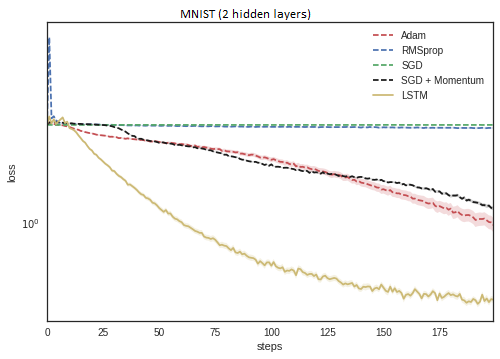

In [3]:
from IPython.display import Image, display
display(Image(filename='img/Comparison between standard optimizers and learned optimizer (LSTM) - MNIST (2-layer network).png', embed=True))

This produces the above graph which indicates that our learned optimizer performs better than standard optimizers
even if we add another hidden layer in our MLP architecture despite operating outside of its training regime.

/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


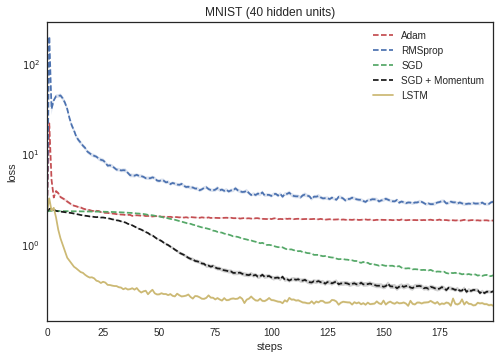

In [148]:
MNIST_40HIDDENSIZE_LEARNING_RATES = [1.0, 1.0, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), MNIST_40HIDDENSIZE_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTUtil, GenericNeuralNetBig, opt, lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, best_mnist_optimizer, None, MNISTUtil, GenericNeuralNetBig, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (40 hidden units)')
plt.show()

Following the previous experiment, we examined whether instead of adding more layers to the network we could maintain our learned optimizer's performance if we increased the number of neurons in the single hidden layer. The above graph indicates that our learned optimizer still performs better than standard optimizers even if we alter the number of neurons in our MLP architecture.

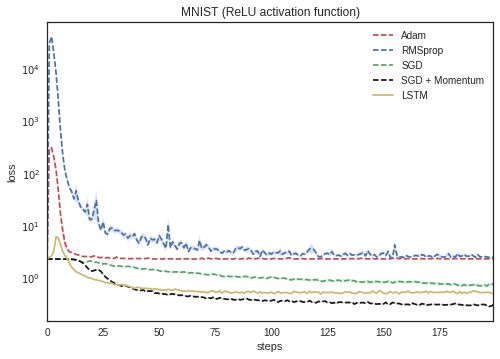

In [152]:
MNIST_RELU_LEARNING_RATES = [1.0, 1.0, 1.0, 0.3]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), MNIST_RELU_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTUtil, GenericNeuralNetRelu, opt, lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, best_mnist_optimizer, None, MNISTUtil, GenericNeuralNetRelu, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU activation function)')
plt.show()

In this last experiment on the MNIST dataset we tested whether changing the activation function in our MLP would have any consequence on our learned optimizer's performance. Indeed SGD with Momentum proves to perform better than our learned optimizer, however it still manages to surpass the rest of the hand-designed optimization algorithms, even though the alteration of the activation function in general leads to severe changes in the learning dynamics.

In [15]:
class Generic3DNeuralNet(nn.Module):
    def __init__(self, layer_size = 20, n_layers = 1, input_size = 32*32, color_channels = 3, **kwargs):
        super().__init__()
        if kwargs != {}:
            self.params = kwargs
        else:
            input_size = 3*32*32
            self.params = {}
            # Initialize parameter values for weight and bias
            for i in range(n_layers):
                weight_name = 'weight_' + str(i)
                bias_name = 'bias_' + str(i)
                self.params[weight_name] = nn.Parameter(torch.randn(input_size, layer_size) * 0.001)
                self.params[bias_name] = nn.Parameter(torch.zeros(layer_size))
                input_size = layer_size
                
            self.params['final_weight'] = nn.Parameter(torch.randn(input_size, 10) * 0.001)
            self.params['final_bias'] = nn.Parameter(torch.zeros(10))
            
            # Put it all in a module list so that ordinary optimizers can find them.
            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
                
        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()
        
    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(-1, self.color_channels * self.input_size)))
        #inp = w(Variable(inp.view(inp.size()[0], self.input_size*self.input_size)))
        out = w(Variable(out))
        
        cur_layer = 0
        while 'weight_' + str(cur_layer) in self.params:
            inp = self.activation(torch.matmul(inp, self.params['weight_' + str(cur_layer)].double()) + 
                                               self.params['bias_' + str(cur_layer)].double())
            cur_layer += 1
            
        inp = F.log_softmax(torch.matmul(inp, self.params['final_weight'].double()) + self.params['final_bias'].double())
        l = self.loss(inp, out)
        
        return l

In [16]:
class CIFARUtil:
    def __init__(self, training = True):
        # Download the MNIST dataset
        dataset = datasets.CIFAR10('./cifar10', train=True, download=False, transform=torchvision.transforms.ToTensor())
        
        """
        dataset_size = len(dataset)
        
        data_loader = DataLoader(dataset, batch_size=dataset_size)
        all_data = {}
        for i_batch, sample_batched in tqdm(enumerate(data_loader)):
            all_data = sample_batched
        
        print(all_data[0].shape)
        print(np.unique(all_data[1]))
        
        # Take all the indices in the dataset, shuffle them, then do a training/test split
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]
        """
        
        
        
        # Create random samples from the training data in order for them to act as mini-batches
        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128, sampler=torch.utils.data.sampler.SubsetRandomSampler(indices)
        )
        
        self.batches = []
        self.cur_batch = 0
    
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

In [17]:
class GenericNeuralNetCifar(Generic3DNeuralNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_size = 32*32
        self.color_channels = 3

In [202]:
for optimizer_name, kwargs in zip(OPTIMIZER_NAMES, OPTIMIZER_PARAMETERS):
    print(find_best_lr_normal(CIFARUtil, Ge nericNeuralNetCifar, opt, **kwargs, n_tests=10))

Files already downloaded and verified


/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


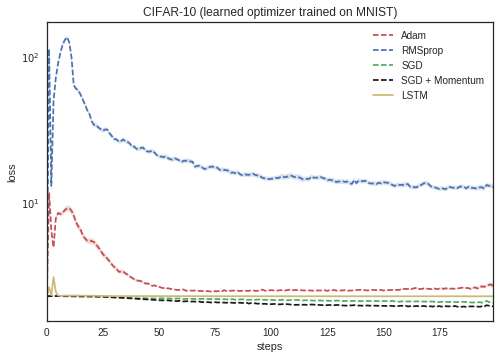

In [28]:
CIFAR_LEARNING_RATES = [1.0, 1.0, 1.0, 0.3]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), CIFAR_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(CIFARUtil, GenericNeuralNetCifar, opt, lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, best_mnist_optimizer, None, CIFARUtil, GenericNeuralNetCifar, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('CIFAR-10 (learned optimizer trained on MNIST)')
plt.show()

In order to test our learned optimizer's performance in more datasets, we tested its generalization capabilities on CIFAR-10, a different dataset with colored images belonging to 10 distinct classes of objects. Although SGD and SGD with Momentum perform better than our learned optimizer, the difference in terms of performance is negligible, if one accounts to the fact that optimizing the objective functions for CIFAR-10 poses a different and more challenges task for our learned optimizer.

In [19]:
class FashionMNISTUtil:
    def __init__(self, training = True):
        # Download the MNIST dataset
        dataset = datasets.FashionMNIST('./fashionmnist', train=True, download=True, transform=torchvision.transforms.ToTensor())
        # Take all the indices in the dataset, shuffle them, then do a training/test split
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]
        
        # Create random samples from the training data in order for them to act as mini-batches
        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128, sampler=torch.utils.data.sampler.SubsetRandomSampler(indices)
        )
        
        self.batches = []
        self.cur_batch = 0
    
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

In [31]:
for optimizer_name, kwargs in zip(OPTIMIZER_NAMES, OPTIMIZER_PARAMETERS):
    print(find_best_lr_normal(FashionMNISTUtil, GenericNeuralNet, optimizer_name, **kwargs, n_tests=10))

/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(108.48456, 0.03)
(118.77787, 0.01)
(164.56659, 1.0)
(113.70819, 1.0)


/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


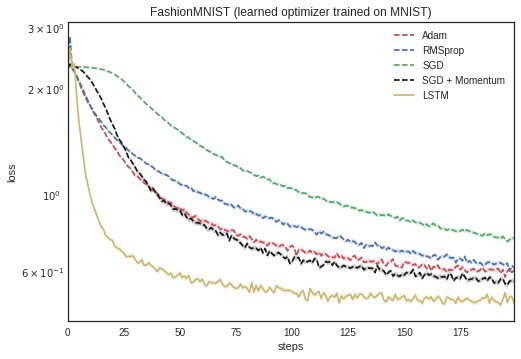

In [32]:
FASHIONMNIST_LEARNING_RATES = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), FASHIONMNIST_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(FashionMNISTUtil, GenericNeuralNet, opt,
                                            lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, best_mnist_optimizer, None, FashionMNISTUtil,
                                                                  GenericNeuralNet, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('FashionMNIST (learned optimizer trained on MNIST)')
plt.show()

Let's try and meta-learn an optimizer suited for the CIFAR-10 dataset

In [ ]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001],  
                      key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(main_loop(CIFARUtil, GenericNeuralNetCifar, lr=lr, out_mul=0.1, preprocessing=True, n_tests=5, epochs=10)[0])

In [ ]:
best_cifar_loss, best_cifar_optimizer = main_loop(CIFARUtil, GenericNeuralNetCifar, lr=0.01, epochs=20, 
                                            n_tests=20, out_mul=0.1, preprocessing=True)
print(best_cifar_loss)

In [ ]:
CIFAR_LEARNING_RATES = [1.0, 1.0, 1.0, 0.3]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), CIFAR_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(CIFARUtil, GenericNeuralNetCifar, opt, lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, best_cifar_optimizer, None, CIFARUtil, GenericNeuralNetCifar, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('CIFAR-10 (learned optimizer trained on CIFAR)')
plt.show()

We can also test the generalization capabilities of our learned optimizer on MNIST on the EMNIST dataset. The EMNIST dataset is a handwritten letters dataset making this optimization problem a bit different than that of the MNIST (or FashionMNIST dataset) due to it having to choose between 26 classes instead of 10.

In [18]:
class EMNISTNeuralNet(nn.Module):
    def __init__(self, layer_size = 20, n_layers = 1, **kwargs):
        super().__init__()
        if kwargs != {}:
            input_size = 28*28
            self.params = kwargs
        else:
            input_size = 28*28
            self.params = {}
            # Initialize parameter values for weight and bias
            for i in range(n_layers):
                weight_name = 'weight_' + str(i)
                bias_name = 'bias_' + str(i)
                self.params[weight_name] = nn.Parameter(torch.randn(input_size, layer_size) * 0.001)
                self.params[bias_name] = nn.Parameter(torch.zeros(layer_size))
                input_size = layer_size
                
            self.params['final_weight'] = nn.Parameter(torch.randn(input_size, 27) * 0.001)
            self.params['final_bias'] = nn.Parameter(torch.zeros(27))
            
            # Put it all in a module list so that ordinary optimizers can find them.
            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
                
        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()
        
    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))
        
        cur_layer = 0
        while 'weight_' + str(cur_layer) in self.params:
            inp = self.activation(torch.matmul(inp, self.params['weight_' + str(cur_layer)]) + 
                                               self.params['bias_' + str(cur_layer)])
            cur_layer += 1
            
        inp = F.log_softmax(torch.matmul(inp, self.params['final_weight']) + self.params['final_bias'])
        l = self.loss(inp, out)
        
        return l

In [19]:
class EMNISTUtil:
    def __init__(self, training = True):
        # Download the MNIST dataset
        dataset = datasets.EMNIST('./emnist', train=True, download=False, split = 'letters', transform=torchvision.transforms.ToTensor())
        
        #dataset_size = len(dataset)
        
        #data_loader = DataLoader(dataset, batch_size=dataset_size)
        #all_data = {}
        #for i_batch, sample_batched in tqdm(enumerate(data_loader)):
        #    all_data = sample_batched
        
        #print(all_data[0].shape)
        #print(np.unique(all_data[1]))

        # Take all the indices in the dataset, shuffle them, then do a training/test split
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]
        
        # Create random samples from the training data in order for them to act as mini-batches
        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128, sampler=torch.utils.data.sampler.SubsetRandomSampler(indices)
        )
        
        self.batches = []
        self.cur_batch = 0
    
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

In [114]:
for optimizer_name, kwargs in zip(OPTIMIZER_NAMES, OPTIMIZER_PARAMETERS):
    print(find_best_lr_normal(EMNISTUtil, EMNISTNeuralNet, optimizer_name, **kwargs, n_tests=10))

/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(236.22232, 0.03)
(238.07364, 0.01)
(321.15292, 1.0)
(253.10136, 1.0)


/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


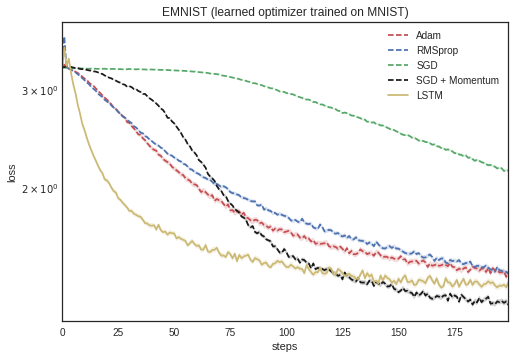

In [17]:
EMNIST_LEARNING_RATES = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), EMNIST_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(EMNISTUtil, EMNISTNeuralNet, opt, lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, best_mnist_optimizer, None, EMNISTUtil, EMNISTNeuralNet, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('EMNIST (learned optimizer trained on MNIST)')
plt.show()

Since training on CIFAR didn't go as planned (too large a dataset) we are going to use a similar one called STL10. This dataset consists of 96x96 colored images divided in 10 classes. The training images are very few (500 training images) so, depending on our optimizer's performance, we could also check its performance on few-shot learning tasks.

In [25]:
class GenericNeuralNetSTL10(nn.Module):
    def __init__(self, layer_size = 20, n_layers = 1, input_size = 96*96, color_channels = 3, **kwargs):
        super().__init__()
        if kwargs != {}:
            self.params = kwargs
        else:
            self.input_size = 96*96
            self.color_channels = 3
            self.params = {}
            # Initialize parameter values for weight and bias
            for i in range(n_layers):
                weight_name = 'weight_' + str(i)
                bias_name = 'bias_' + str(i)
                self.params[weight_name] = nn.Parameter(torch.randn(3*input_size, layer_size) * 0.001)
                self.params[bias_name] = nn.Parameter(torch.zeros(layer_size))
                input_size = layer_size
                
            self.params['final_weight'] = nn.Parameter(torch.randn(input_size, 10) * 0.001)
            self.params['final_bias'] = nn.Parameter(torch.zeros(10))
            
            # Put it all in a module list so that ordinary optimizers can find them.
            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
                
        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()
        
    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(-1, 3*96*96)))
        #inp = w(Variable(inp.view(inp.size()[0], self.input_size*self.input_size)))
        out = w(Variable(out))
        
        cur_layer = 0
        while 'weight_' + str(cur_layer) in self.params:
            inp = self.activation(torch.matmul(inp, self.params['weight_' + str(cur_layer)]) + 
                                               self.params['bias_' + str(cur_layer)])
            cur_layer += 1
            
        inp = F.log_softmax(torch.matmul(inp, self.params['final_weight']) + self.params['final_bias'])
        l = self.loss(inp, out)
        
        return l

In [26]:
from torch.utils.data import SubsetRandomSampler

class STL10Util:
    def __init__(self, training = True):
        # Download the MNIST dataset
        folds = np.loadtxt("/home/nikos/Desktop/MSc Thesis/MetaLearning-MScThesis/stl10/stl10_binary/fold_indices.txt")
        train_fold = folds[0]
        test_fold = folds[1]
        
        dataset = datasets.STL10('./stl10', download=False, split = 'train', 
                                     transform=torchvision.transforms.ToTensor())
        
        if training:
            self.loader = torch.utils.data.DataLoader(dataset, batch_size=128, 
                                                           sampler=SubsetRandomSampler(train_fold), num_workers=2,pin_memory=False)
        else:
            self.loader = torch.utils.data.DataLoader(dataset, batch_size=128, 
                                                           sampler=SubsetRandomSampler(test_fold), num_workers=2,pin_memory=False)
        
        self.batches = []
        self.cur_batch = 0
    
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

In [24]:
for optimizer_name, kwargs in zip(OPTIMIZER_NAMES, OPTIMIZER_PARAMETERS):
    print(find_best_lr_normal(STL10Util, GenericNeuralNetSTL10, optimizer_name, **kwargs, n_tests=10))

(225.7933, 0.001)
(228.31656, 0.0001)
(218.72659, 0.3)
(211.07047, 0.1)


In [ ]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001],  
                      key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(main_loop(STL10Util, GenericNeuralNetSTL10, lr=lr, out_mul=0.1, preprocessing=True, n_tests=5, epochs=10)[0])

In [ ]:
best_stl_loss, best_stl_optimizer = main_loop(STL10Util, GenericNeuralNetSTL10, lr=0.01, epochs=20, 
                                            n_tests=20, out_mul=0.1, preprocessing=True)
print(best_stl_loss)

In [ ]:
STL10_LEARNING_RATES = [0.001, 0.0001, 0.3, 0.1]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), STL10_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(STL10Util, GenericNeuralNetSTL10, opt, lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, best_mnist_optimizer, None, STL10Util, GenericNeuralNetSTL10, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('STL10 (learned optimizer trained on STL10)')
plt.show()

It is also usefull to check whether our meta-learned optimizer on STL-10 generalizes on MNIST (and maybe its variants).

In [ ]:
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), MNIST_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTUtil, GenericNeuralNet, opt, lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, best_stl_optimizer, None, MNISTUtil, GenericNeuralNet, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (learned optimizer trained on STL10)')
plt.show()

Finally, we check the generalization of our meta-learned optimizer on MNIST on another dataset which is called The Street View House Numbers (SVHN) Dataset. It consists of 32x32 colored images containing number digits of street signs. While we have tested our meta-learned optimizer's performance at recognizing number digits, this problem differenciates from that of MNIST and its variants as the images here are colored.

In [22]:
class GenericNeuralNetSVHN(Generic3DNeuralNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_size = 32*32
        self.color_channels = 3

In [25]:
class SVHNUtil:
    def __init__(self, training = True):
        # Download the MNIST dataset
        if training:
            dataset = datasets.SVHN('./svhn', download=False, split = 'train', transform=torchvision.transforms.ToTensor())
        else:
            dataset = datasets.SVHN('./svhn', download=False, split = 'test', transform=torchvision.transforms.ToTensor())

        # Take all the indices in the dataset, shuffle them, then do a training/test split
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        
        # Create random samples from the training data in order for them to act as mini-batches
        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128, sampler=torch.utils.data.sampler.SubsetRandomSampler(indices)
        )
        
        self.batches = []
        self.cur_batch = 0
    
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

In [26]:
for optimizer_name, kwargs in zip(OPTIMIZER_NAMES, OPTIMIZER_PARAMETERS):
    print(find_best_lr_normal(SVHNUtil, GenericNeuralNetSVHN, optimizer_name, **kwargs, n_tests=10))

/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(222.70459, 0.003)
(222.46585, 0.001)
(222.7989, 0.3)
(222.32918, 0.3)


/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


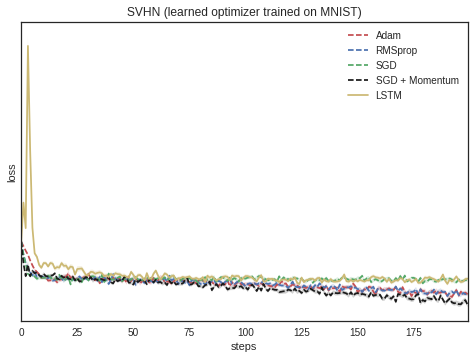

In [29]:
N_TESTS = 100
SVHN_LEARNING_RATES = [0.003, 0.001, 0.3, 0.3]

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), SVHN_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(SVHNUtil, GenericNeuralNetSVHN, opt, lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, best_mnist_optimizer, None, SVHNUtil, GenericNeuralNetSVHN, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('SVHN (learned optimizer trained on MNIST)')
plt.show()

In [14]:
from torch.utils.data.dataset import Dataset

class CIFARFewShotDataset(Dataset):
    def __init__(self, samples_per_class_train = 5, samples_per_class_test = 1):
        # Download the CIFAR dataset
        dataset = datasets.CIFAR10('./cifar10', train=True, download=False, transform=torchvision.transforms.ToTensor())

        indices = list(range(len(dataset)))
        dataset_size = len(dataset)
        data_loader = DataLoader(dataset, batch_size = dataset_size)
        all_data = {}
        for i_batch, sample_batched in enumerate(data_loader):
            all_data = sample_batched
        
        y = all_data[1]
        self.classes = np.unique(y)
        self.samples_per_class_train = samples_per_class_train
        self.samples_per_class_test = samples_per_class_test
        
        self.train_indices = []
        self.test_indices = []
        samples_per_class_in_train = np.zeros(self.classes.shape[0])
        samples_per_class_in_test = np.zeros(self.classes.shape[0])
        
        for i in range(len(y)):
            if samples_per_class_in_train[y[i]] < self.samples_per_class_train:
                samples_per_class_in_train[y[i]] += 1
                self.train_indices.append(i)
                    
        for i in range(len(y)):
            if samples_per_class_in_test[y[i]] < self.samples_per_class_test and i not in self.train_indices:
                samples_per_class_in_test[y[i]] += 1
                self.test_indices.append(i)
        
        np.random.RandomState(10).shuffle(self.train_indices)
        np.random.RandomState(10).shuffle(self.test_indices)
        
        self.X = torch.tensor(np.zeros((60, 3, 32, 32)))
        #self.y = torch.tensor(np.zeros(60))
        self.y = []
        #print(all_data[0].shape)
        #print(all_data[0][0].shape)
        count = 0
        for index in self.train_indices:
            self.X[count] = all_data[0][index]
            self.y.append(all_data[1][index])
            count += 1
            
        for index in self.test_indices:
            self.X[count] = all_data[0][index]
            self.y.append(all_data[1][index])
            count += 1
                    
        #print(self.X.shape)
        self.y = np.asarray(self.y)
        #print(self.y)
        self.X = self.X.double()
        
    def __getitem__(self, index):
        return (self.X[index], self.y[index])
    
    def __len__(self):
        return self.y.shape[0]

In [15]:
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader

class CIFARFewShotUtil:
    def __init__(self, training = True, samples_per_class_train = 5, samples_per_class_test = 1):
        
        dataset = CIFARFewShotDataset()
        #print(len(dataset))
        if training:
            indices = [i for i in range(0, 50)]
        else:
            indices = [i for i in range(50, 60)]
        
        # Create random samples from the training data in order for them to act as mini-batches
        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=10, sampler=torch.utils.data.sampler.SubsetRandomSampler(indices)
        )
        
        self.batches = []
        self.cur_batch = 0
    
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

In [43]:
for optimizer_name, kwargs in zip(OPTIMIZER_NAMES, OPTIMIZER_PARAMETERS):
    print(find_best_lr_normal(CIFARFewShotUtil, GenericNeuralNetCifar, optimizer_name, **kwargs, n_tests=10))

/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(90.557738835438471, 1.0)
(68.311741036309655, 0.1)
(93.609990759051627, 1.0)
(52.500054910386055, 0.3)


In [ ]:
for lr in tqdm(sorted([0.01],  
                      key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(main_loop(EMNISTUtil, EMNISTNeuralNet, lr=lr, out_mul=0.1, preprocessing=True, n_tests=5, epochs=10)[0])

Trying lr: 0.01


/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


207.899


In [20]:
best_emnist_loss, best_emnist_optimizer = main_loop(EMNISTUtil, EMNISTNeuralNet, lr = 0.01, epochs = 100)
print(best_loss)

EMNIST_LEARNING_RATES = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPTIMIZER_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(zip(OPTIMIZER_NAMES,OPTIMIZER_PARAMETERS), EMNIST_LEARNING_RATES)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(EMNISTUtil, EMNISTNeuralNet, opt, lr=lr, n_tests=N_TESTS, epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(OptimizerNetwork(preprocessing=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPTIMIZER_NAMES)] = np.array(get_fit_dict_test(N_TESTS, best_emnist_optimizer, None, EMNISTUtil, EMNISTNeuralNet, 200, 1, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPTIMIZER_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('EMNIST')
plt.show()

/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


327.065
327.008
326.861
326.883
326.91
326.035
327.226
326.895
326.477
326.118
326.059
326.723
327.24
327.043
326.328
326.245
326.298
326.364
326.073
326.239
326.456
327.045
326.69
326.296
326.147
326.081
326.191
326.335
326.441
326.109
326.998
326.011
325.987
325.995
325.999


KeyboardInterrupt: 